# Cleaning data and the skies - Ozone Analysis Report

This project analyzes ozone pollution trends across California using 2024 EPA monitoring data.

Our objectives were:
Clean and prepare the dataset for reliable analysis.
Identify high-risk regions and time periods.
Compare measurement methods for consistency.
Explore the impact of urban activity (weekend vs weekday) on ozone levels.
Create visualizations to support policy recommendations.

## Dataset Overview

The dataset contains 54,759 daily ozone measurements collected across California in 2024 from both EPA’s Air Quality System (AQS) and AirNow monitoring networks.It includes key variables such as ozone concentration, Air Quality Index (AQI), monitoring site details, and geographic coordinates, along with metadata like method codes and percent completeness.The data exhibits missing values, inconsistent formats, and potential duplicates, requiring thorough cleaning before meaningful analysis can be performed.

## Imports Used
I used pandas and numpy for data manipulation and cleaning, and matplotlib with seaborn for statistical visualizations.folium was included for geospatial mapping, dateutil.parser for parsing inconsistent date formats, and scipy.stats.ttest_ind for statistical testing between groups.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from dateutil import parser
from scipy.stats import ttest_ind

## Loading Dataset

In [2]:
df = pd.read_csv("data/ozone.csv")

print("Initial Shape:", df.shape)
df.head()

Initial Shape: (54759, 17)


,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54759 entries, 0 to 54758
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  54759 non-null  object 
 1   Source                                54759 non-null  object 
 2   Site ID                               54759 non-null  int64  
 3   POC                                   54759 non-null  int64  
 4   Daily Max 8-hour Ozone Concentration  52021 non-null  float64
 5   Units                                 54759 non-null  object 
 6   Daily AQI Value                       52021 non-null  float64
 7   Local Site Name                       54759 non-null  object 
 8   Daily Obs Count                       54759 non-null  int64  
 9   Percent Complete                      54759 non-null  float64
 10  Method Code                           48269 non-null  float64
 11  CBSA Code      

In [4]:
df.isnull().sum()

Date                                       0
Source                                     0
Site ID                                    0
POC                                        0
Daily Max 8-hour Ozone Concentration    2738
Units                                      0
Daily AQI Value                         2738
Local Site Name                            0
Daily Obs Count                            0
Percent Complete                           0
Method Code                             6490
CBSA Code                               2408
CBSA Name                               2408
County FIPS Code                           0
County                                     0
Site Latitude                              0
Site Longitude                             0
dtype: int64

In [34]:
df['Source'].value_counts()

Source
AQS       42428
AirNow     5848
Name: count, dtype: int64

## EDA and Data Cleaning

## Data Cleaning


### 1. Fix messy dates

Parses inconsistent date formats (e.g., `"01-02-2024"`, `"January 04/2024"`) into a standard datetime format.
Removes any rows where the date could not be interpreted.

---

### 2. Convert ppm to ppb

Converts ozone measurements from parts per million (ppm) to parts per billion (ppb) for better interpretability.
Filters out any values outside the 0–300 ppb range(done after considering the min and max values)

---

### 3. Standardize text

Cleans county and site names by removing extra spaces and converting them to title case.
Ensures consistent naming for easier grouping and analysis.

---

### 4. Remove duplicates

Eliminates duplicate rows that represent the same date, location, and measurement.
Prevents repeated values from biasing analysis results.

---

### 5. Fill missing ozone values

Fills missing ozone concentration values using the median of the same monitoring site and month.
If still missing, fills with the median for that month across all sites.

---

### 6. Fill missing AQI values

Converts AQI values to numeric and replaces missing entries with the median for the same county and month.
Ensures AQI data is complete for time‑series and regional analysis.

---

### 7. Fill missing Method Code

Imputes missing method codes using the most common method for the same site.
Assigns `"Unknown"` if no mode could be determined.

---

### 8. Fill missing CBSA Name & Code

Replaces missing CBSA details with the most common values for the same county.
If still missing, assigns `"Not Assigned"` to maintain consistency.

---

### 9. Remove incomplete observations (<75% completeness)

Filters out records where less than 75% of expected daily observations were collected.
Ensures only reliable and representative measurements remain in the dataset.

---

### 10. Add useful columns

Adds month, day‑of‑week, and weekend flags for time‑based and behavioral analysis.
Facilitates grouping by temporal patterns in later visualizations.

In [5]:
# Fixing messy dates
def parse_messy_date(x):
    try:
        return parser.parse(str(x), fuzzy=True, dayfirst=False)
    except:
        return pd.NaT

In [6]:
df['Date'] = df['Date'].apply(parse_messy_date).dt.strftime('%Y-%m-%d')
df = df.dropna(subset=['Date'])

In [7]:
df.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,2024-08-04,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,2024-01-02,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,2024-08-04,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,2024-01-04,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,2024-01-05,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217


In [8]:
df['Daily Max 8-hour Ozone Concentration'].min()

0.0

In [9]:
# Converting ppm to ppb
df['Ozone_ppb'] = pd.to_numeric(df['Daily Max 8-hour Ozone Concentration'], errors='coerce') * 1000
df = df[df['Ozone_ppb'].between(0, 300)]

In [10]:
df.head()

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude,Ozone_ppb
0,2024-08-04,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,31.0
1,2024-01-02,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,37.0
3,2024-01-04,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,26.0
4,2024-01-05,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,27.0
5,2024-01-06,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217,31.0


In [11]:
# Cleaning the names
df['County'] = df['County'].str.strip().str.title()
df['Local Site Name'] = df['Local Site Name'].str.strip().str.title()

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(48310, 18)

In [14]:
# Fill missing ozone values
df['month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month
df['Ozone_ppb'] = df.groupby(['Site ID', 'month'])['Ozone_ppb'].transform(lambda x: x.fillna(x.median()))
df['Ozone_ppb'] = df.groupby('month')['Ozone_ppb'].transform(lambda x: x.fillna(x.median()))

In [15]:
# Fill missing AQI values
df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
df['Daily AQI Value'] = df.groupby(['County', 'month'])['Daily AQI Value'].transform(lambda x: x.fillna(x.median()))

In [16]:
# Fill missing Method Code
df['Method Code'] = df.groupby('Site ID')['Method Code'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
df['Method Code'] = df['Method Code'].fillna("Unknown")

In [17]:
# Fill missing CBSA Name & Code
df['CBSA Name'] = df.groupby('County')['CBSA Name'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
df['CBSA Code'] = df.groupby('County')['CBSA Code'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
df['CBSA Name'] = df['CBSA Name'].fillna("Not Assigned")
df['CBSA Code'] = df['CBSA Code'].fillna("Not Assigned")

In [18]:
# Remove incomplete observations (<75% completeness)
df = df[df['Percent Complete'] >= 75]

In [19]:
# Adding useful columns
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df['Month'] = df['Date'].dt.month_name()
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])

In [21]:
df['County'].value_counts()

County
Los Angeles        3769
Riverside          3503
San Bernardino     2917
San Diego          2791
Santa Barbara      2735
Kern               2539
Fresno             2265
San Luis Obispo    1898
Ventura            1597
Placer             1593
Sacramento         1565
Alameda            1215
Tulare             1181
Imperial           1089
Santa Clara        1004
Contra Costa        993
Monterey            943
Inyo                880
Shasta              862
Solano              848
El Dorado           677
Madera              656
Orange              645
Stanislaus          641
Yolo                627
San Benito          622
Butte               619
San Joaquin         613
Mariposa            519
Tehama              517
Sutter              509
Mendocino           393
Nevada              334
Tuolumne            334
Merced              330
Colusa              329
Amador              324
Santa Cruz          322
Siskiyou            321
Marin               321
Kings               320
Lake     

In [20]:
print("Cleaned Shape:", df.shape)

Cleaned Shape: (48276, 22)


## After removing duplicates, cleaning the complete data, and filling the missing values with the best measures, the dataset is now clean and ready for obtaining insights and creating visualisations

### Cleaned Shape: (48276,22)

## Visualizations

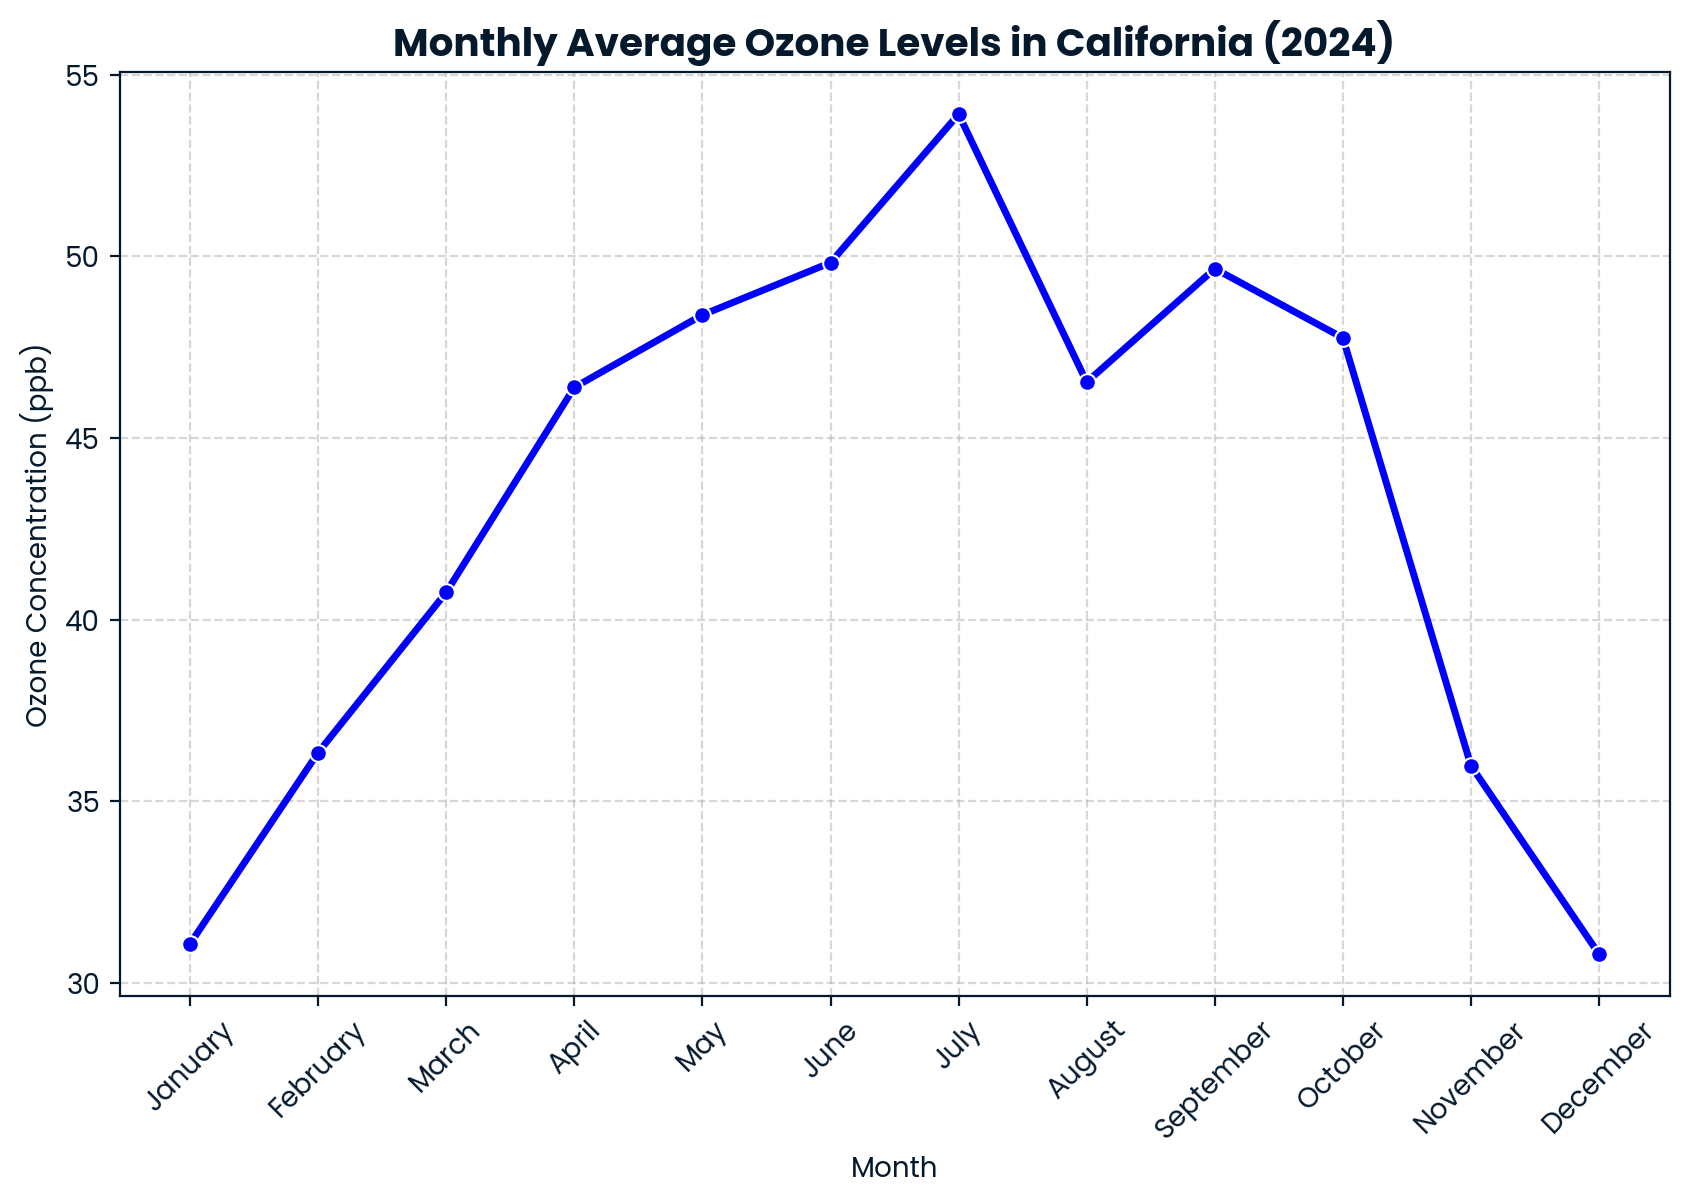

In [22]:
# How ozone concentration varies over time
monthly_trend = df.groupby('Month')['Ozone_ppb'].mean().reindex([
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
])

plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values, marker='o', linewidth=2.5, color='blue')
plt.title("Monthly Average Ozone Levels in California (2024)", fontsize=14, weight='bold')
plt.ylabel("Ozone Concentration (ppb)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

This visualization shows how average ozone concentrations changed month‑by‑month across California in 2024.
The data is aggregated by month, allowing seasonal trends to emerge clearly, with summer months typically showing elevated ozone levels due to increased sunlight and photochemical reactions.
A line chart with markers highlights both the direction and magnitude of changes, making it easy to identify peaks and troughs in pollution levels.
This trend analysis helps pinpoint periods of higher environmental risk, which can inform public health advisories and regulatory focus.

### Key Insight: July witnessed the peak concentration level while December had the least.

In [23]:
# Regional variation
county_avg = df.groupby('County')['Ozone_ppb'].mean().sort_values(ascending=False).head(10)

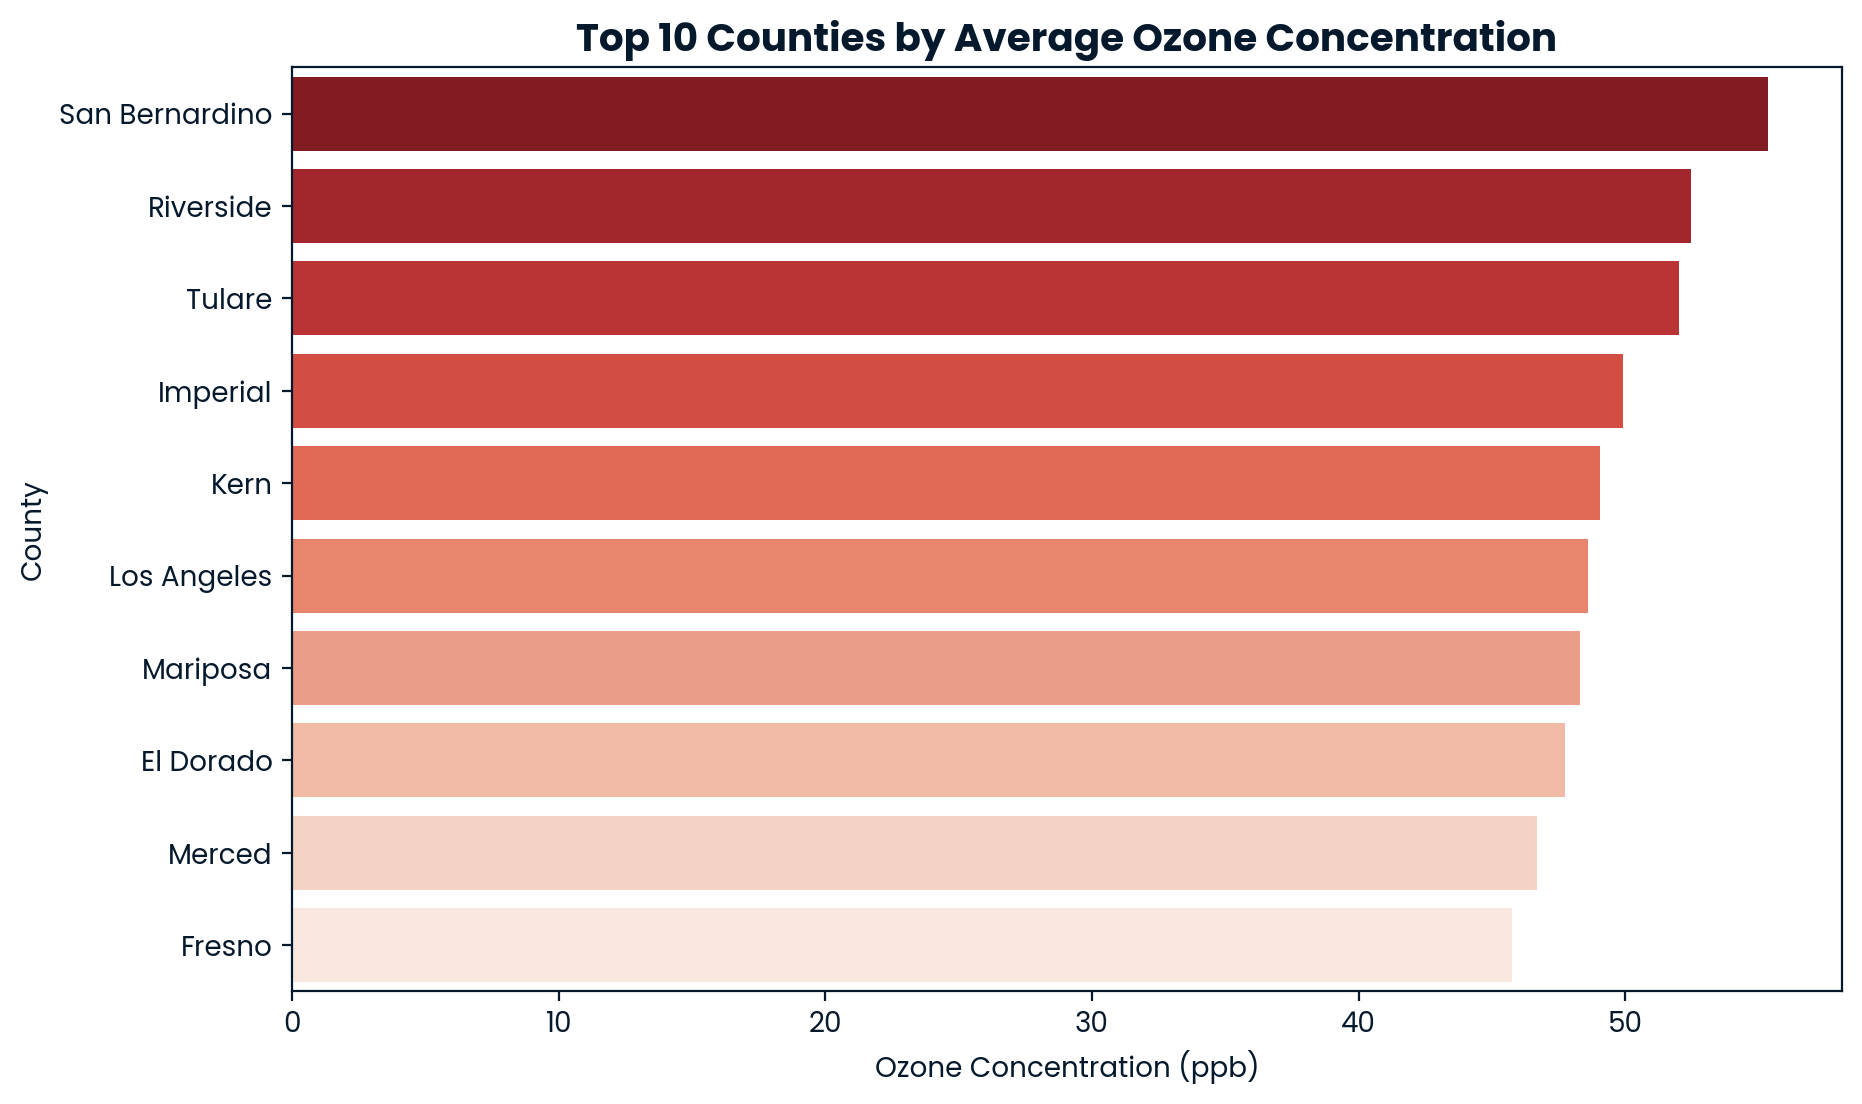

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(x=county_avg.values, y=county_avg.index, palette='Reds_r')
plt.title("Top 10 Counties by Average Ozone Concentration", fontsize=14, weight='bold')
plt.xlabel("Ozone Concentration (ppb)")
plt.show()

This visualization ranks the top 10 California counties by their average ozone concentration in 2024.
By aggregating data at the county level, it highlights regions with the highest long‑term exposure to ozone pollution.
The horizontal bar chart format makes comparisons straightforward, with darker shades representing higher concentrations.
These insights are crucial for identifying high‑risk areas that may require targeted environmental interventions and stricter emission controls.

### Key Insight: San Bernardino had the highest avg ozone concentration, followed by Riverside and Tulare.

In [25]:
# Areas that consistently show high ozone
epa_limit = 70
high_ozone_count = df[df['Ozone_ppb'] > epa_limit].groupby('County').size().sort_values(ascending=False).head(10)
print("Counties exceeding EPA limit most often:\n", high_ozone_count)

Counties exceeding EPA limit most often:
 County
San Bernardino    548
Riverside         449
Los Angeles       392
Kern              285
Tulare            233
Fresno            205
San Diego          57
Imperial           42
Stanislaus         40
Placer             33
dtype: int64


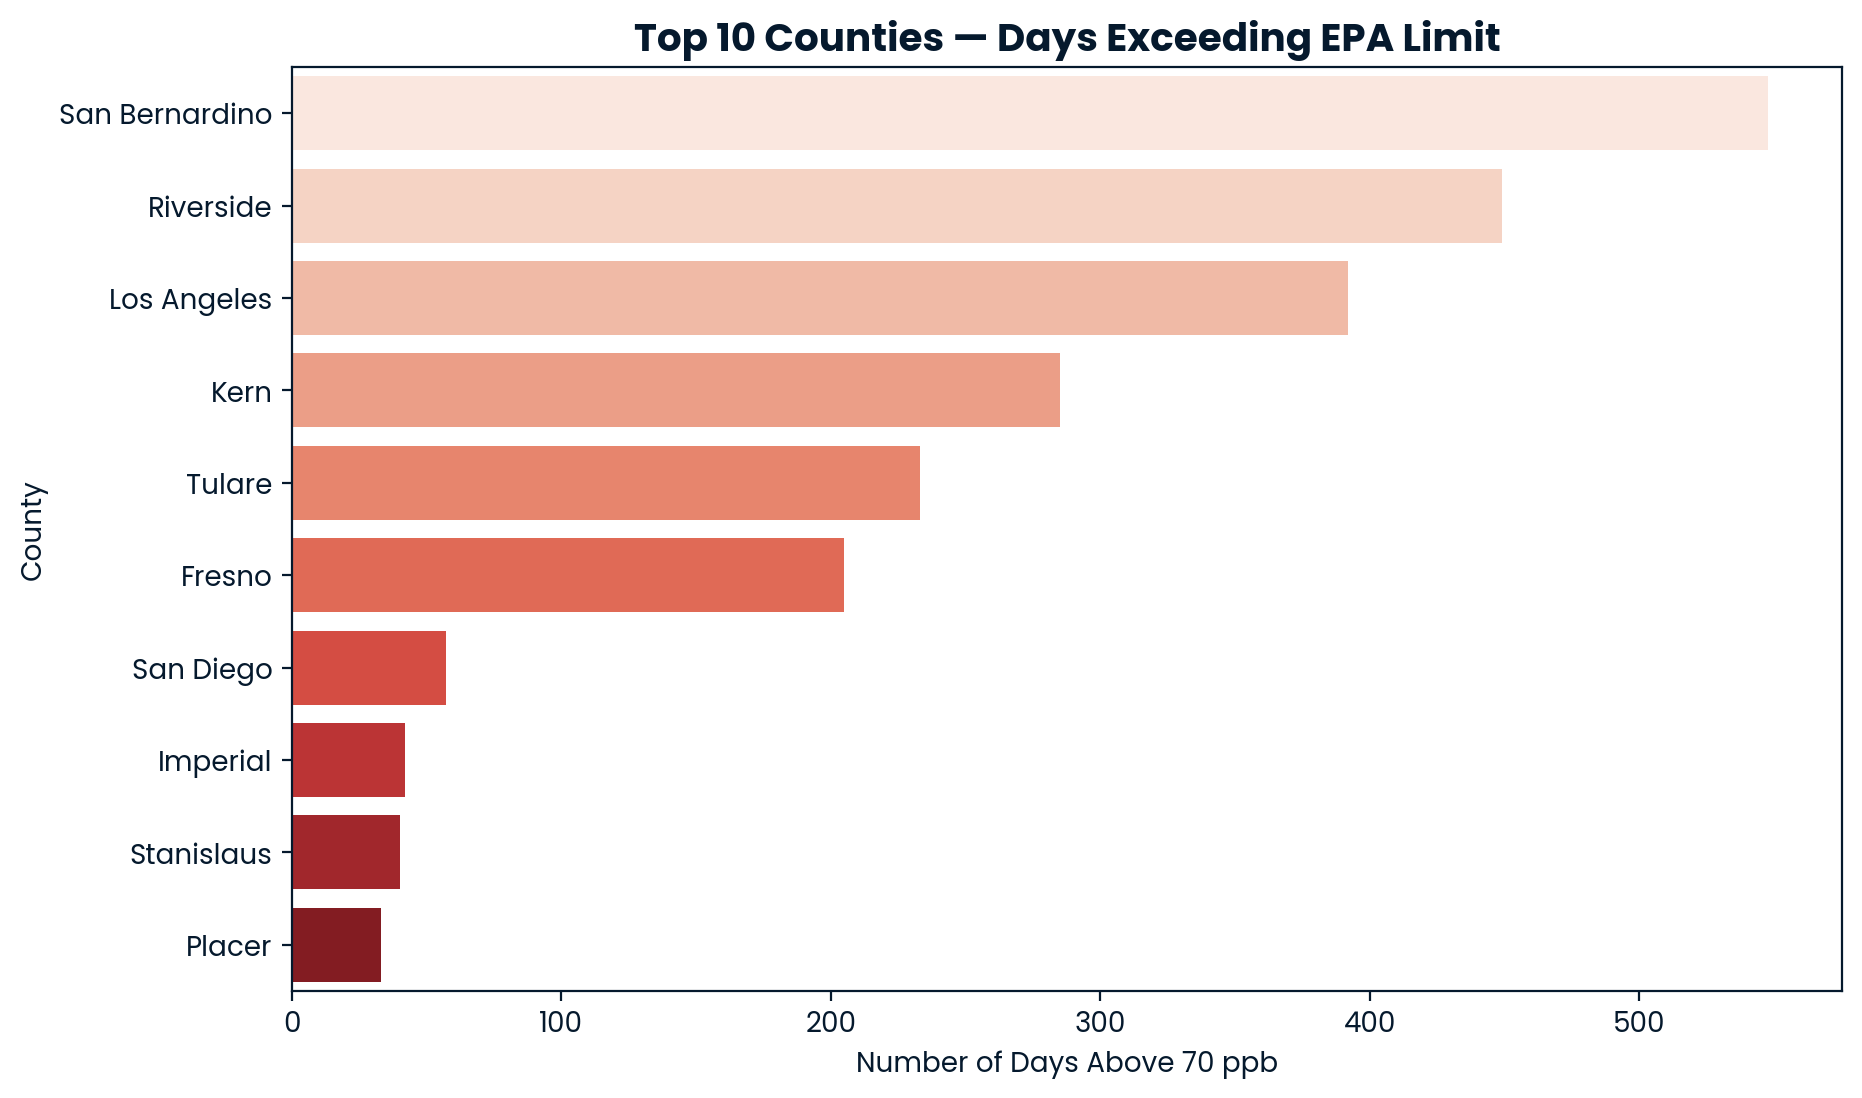

In [26]:
epa_limit = 70
exceedance_count = df[df['Ozone_ppb'] > epa_limit].groupby('County').size().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=exceedance_count.values, y=exceedance_count.index, palette='Reds')
plt.title("Top 10 Counties — Days Exceeding EPA Limit", fontsize=14, weight='bold')
plt.xlabel("Number of Days Above 70 ppb")
plt.show()


This visualization identifies the top 10 counties with the greatest number of days exceeding the U.S. EPA’s ozone safety threshold of 70 ppb.
Rather than focusing on average concentrations, it emphasizes the frequency of high‑pollution events, which pose acute health risks.
The horizontal bar chart format makes it easy to compare how often different regions breach regulatory limits.
These results are particularly useful for prioritizing enforcement actions and issuing timely air quality warnings in vulnerable areas.

### Key Insight: San Bernardino witnessed the most number of days, followed by Riverside and Los Angeles.

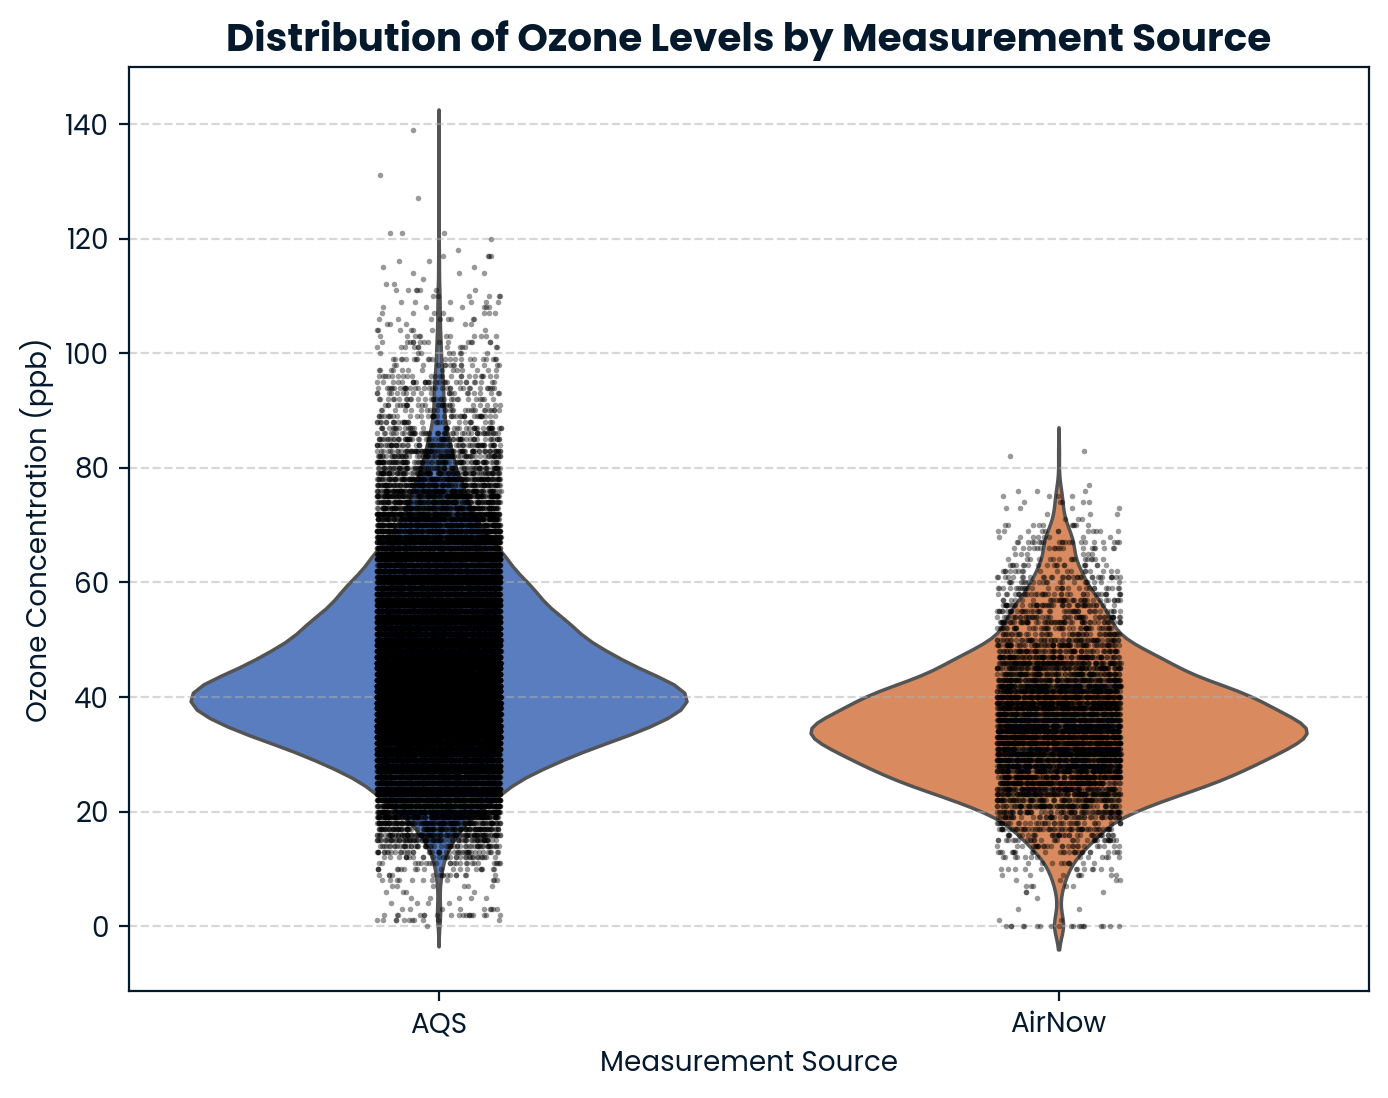

In [27]:
plt.figure(figsize=(8,6))
sns.violinplot(data=df, x='Source', y='Ozone_ppb', palette='muted', inner=None)
sns.stripplot(data=df, x='Source', y='Ozone_ppb', color='black', size=2, alpha=0.4)
plt.title("Distribution of Ozone Levels by Measurement Source", fontsize=14, weight='bold')
plt.ylabel("Ozone Concentration (ppb)")
plt.xlabel("Measurement Source")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


This visualization compares the distribution of ozone concentration measurements between different data sources, such as AQS and AirNow. 
The violin plot displays the full range and density of values.
This makes it easy to spot differences in typical readings, variability, and potential outliers between the two methods.

### Key Insight: AQS has a denser plot while AirNow has a sparse one.

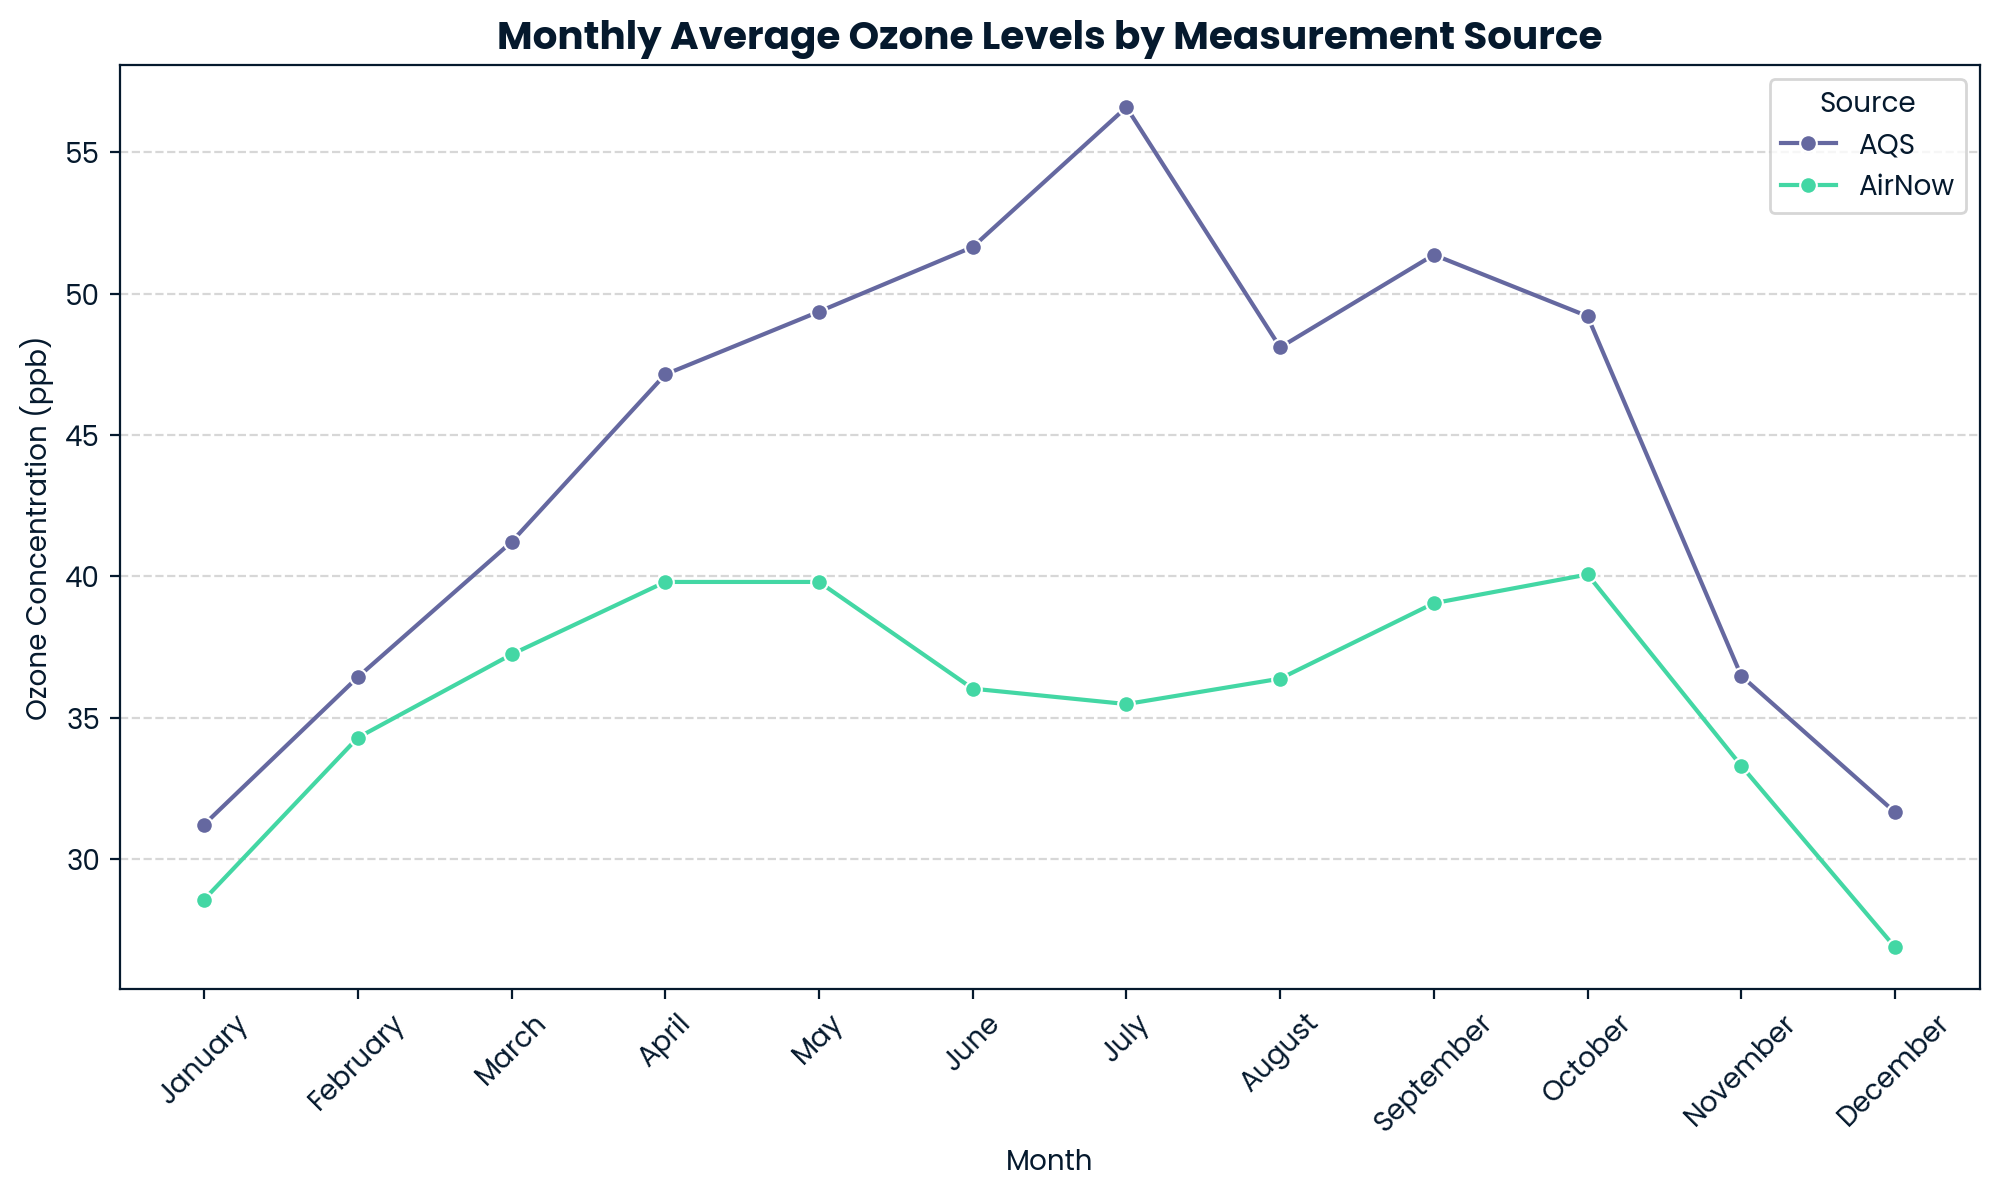

In [35]:
monthly_method_avg = df.groupby([df['Date'].dt.month_name(), 'Source'])['Ozone_ppb'].mean().reset_index()

# Keep months in calendar order
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']

# Apply categorical ordering to month names
monthly_method_avg['Date'] = pd.Categorical(monthly_method_avg['Date'], categories=month_order, ordered=True)

# Sort by month order
monthly_method_avg = monthly_method_avg.sort_values('Date')

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_method_avg, x='Date', y='Ozone_ppb', hue='Source', marker='o')
plt.title("Monthly Average Ozone Levels by Measurement Source", fontsize=14, weight='bold')
plt.ylabel("Ozone Concentration (ppb)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


This visualization shows how monthly average ozone concentrations vary between different measurement sources over the course of 2024.
It plots AQS and AirNow data on the same timeline, making it easy to see if both sources follow similar seasonal trends or diverge in specific months.
The use of markers along the lines emphasizes individual monthly values and highlights fluctuations more clearly.
This comparison helps determine whether differences in reported ozone levels are consistent year‑round or vary seasonally due to methodological factors.

### Key Insight: Max and Min values recieved by AQS are in July and January respectively. While for AirNow, max and min values were observed in October and December respectively

In [29]:
weekdays = df.loc[~df['Weekend'], 'Ozone_ppb']
weekends = df.loc[df['Weekend'], 'Ozone_ppb']
t_stat, p_val = ttest_ind(weekdays, weekends, nan_policy='omit')
print(f"T-test p-value for weekend effect: {p_val:.4f}")

T-test p-value for weekend effect: 0.4827


This code performs a **two-sample t-test** to compare ozone concentration levels between weekdays and weekends.
It calculates whether the difference in means is **statistically significant**, with the p‑value indicating the strength of evidence.
By testing this relationship, we can determine if **urban activity patterns** (e.g., reduced weekday traffic) meaningfully influence ozone pollution levels.
A low p‑value would suggest that weekend and weekday ozone levels differ in a way that is unlikely to be due to random chance.


A p‑value of 0.4827 means there is no statistically significant difference between weekend and weekday ozone concentrations in your dataset.
This suggests that, for California in 2024, urban activity changes between weekdays and weekends did not meaningfully impact ozone levels.
The variation we see in the day‑of‑week chart is likely due to random fluctuations rather than a systematic pattern.

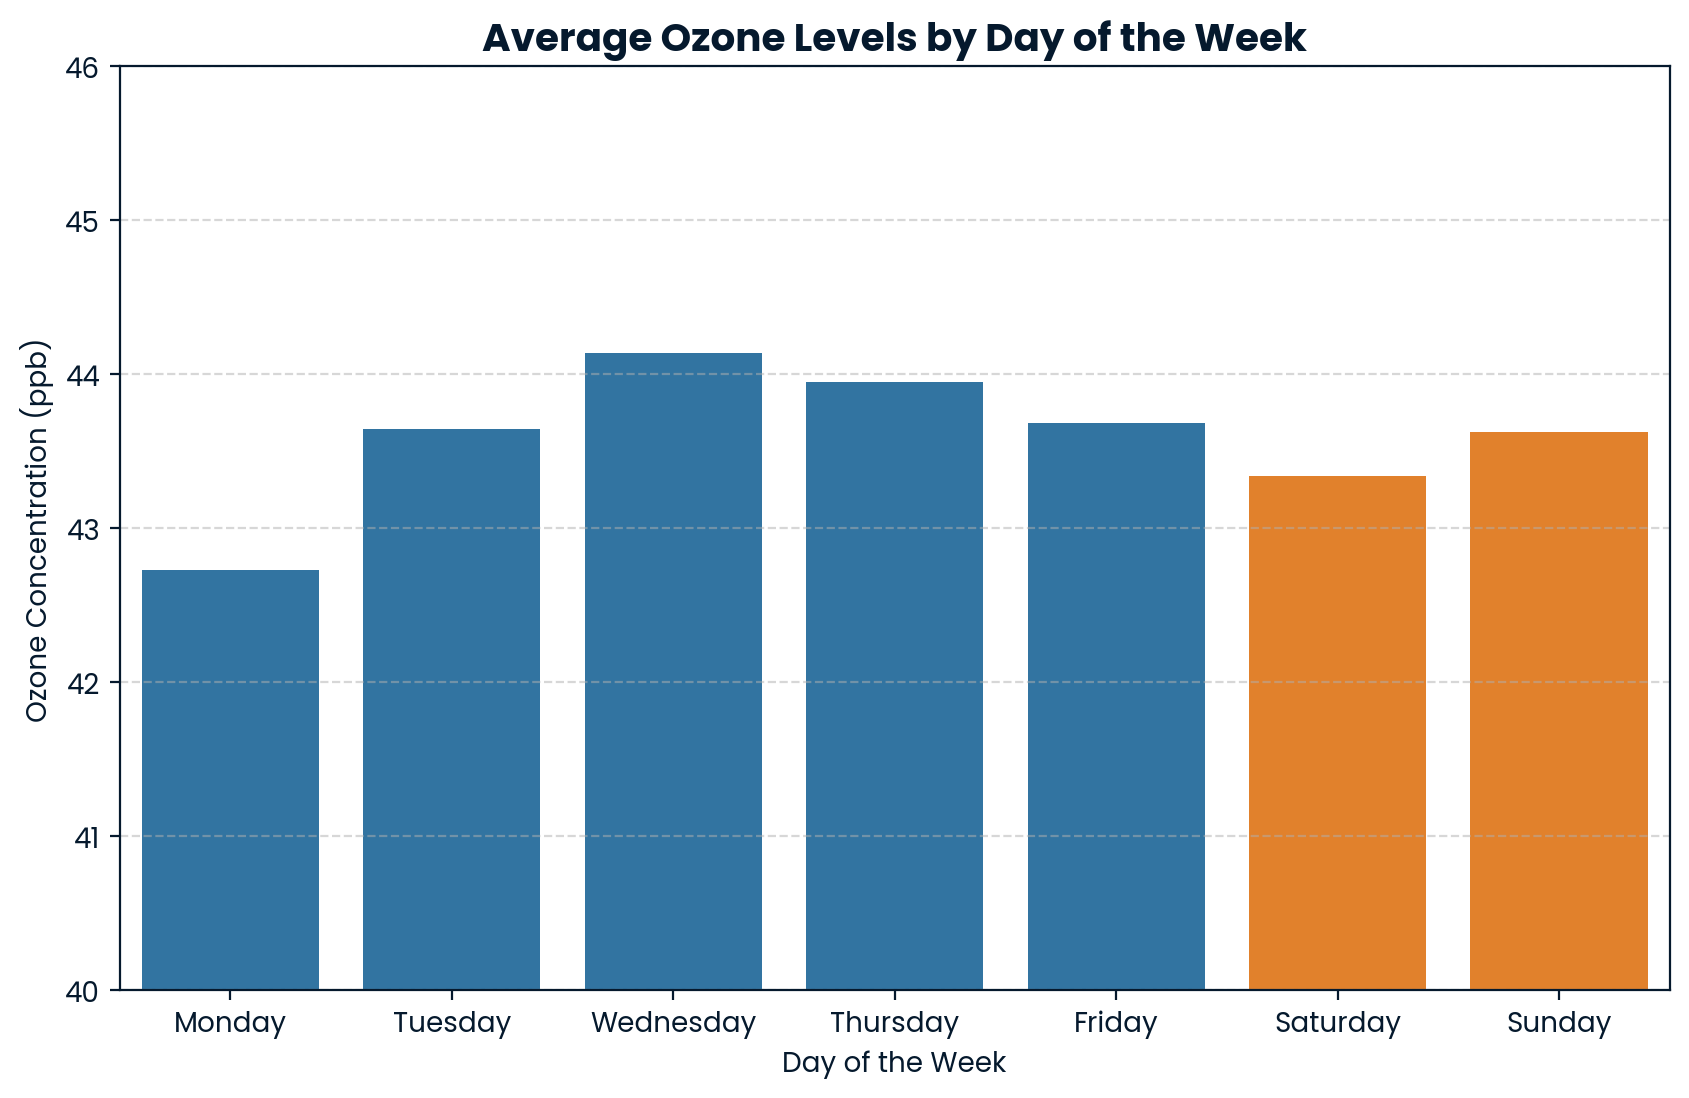

In [30]:
# Average per day of week
dow_avg = df.groupby('DayOfWeek')['Ozone_ppb'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()

plt.figure(figsize=(10,6))
colors = ['#1f77b4' if day not in ['Saturday','Sunday'] else '#ff7f0e' for day in dow_avg['DayOfWeek']]
sns.barplot(data=dow_avg, x='DayOfWeek', y='Ozone_ppb', palette=colors)
plt.title("Average Ozone Levels by Day of the Week", fontsize=14, weight='bold')
plt.ylabel("Ozone Concentration (ppb)")
plt.xlabel("Day of the Week")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(40, 46)
plt.show()

This visualization compares average ozone concentrations across the days of the week.
Weekdays are shown in **blue** and weekends in **orange**, making it easy to spot potential differences related to urban activity patterns.
The chart helps reveal whether ozone levels tend to rise or fall during weekends when traffic and industrial activity may be reduced.
Such insights can support targeted air quality policies and inform public health advisories based on day‑specific pollution trends.

### Key Insight: No clear pattern can be spotted between weekdays and weekends.

In [31]:
site_avg = df.groupby(['Site Latitude', 'Site Longitude'])['Ozone_ppb'].mean().reset_index()

# Calculate threshold (mean or median)
threshold = site_avg['Ozone_ppb'].mean()

m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)
for _, row in site_avg.iterrows():
    folium.CircleMarker(
        location=[row['Site Latitude'], row['Site Longitude']],
        radius=5,
        color='red' if row['Ozone_ppb'] > threshold else 'green',
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['Ozone_ppb']:.1f} ppb"
    ).add_to(m)

m.save("ozone_heatmap.html")
m

This visualization uses an interactive **geospatial heatmap** to show average ozone concentrations across monitoring sites in California.

Each site is represented by a circle marker, with **red** indicating concentrations above the statewide average and **green** indicating lower levels.

The map allows users to zoom in and explore local pollution levels, making it easy to identify geographic clusters of high ozone.

This spatial perspective is critical for linking pollution patterns to geography, topography, and potential emission sources.

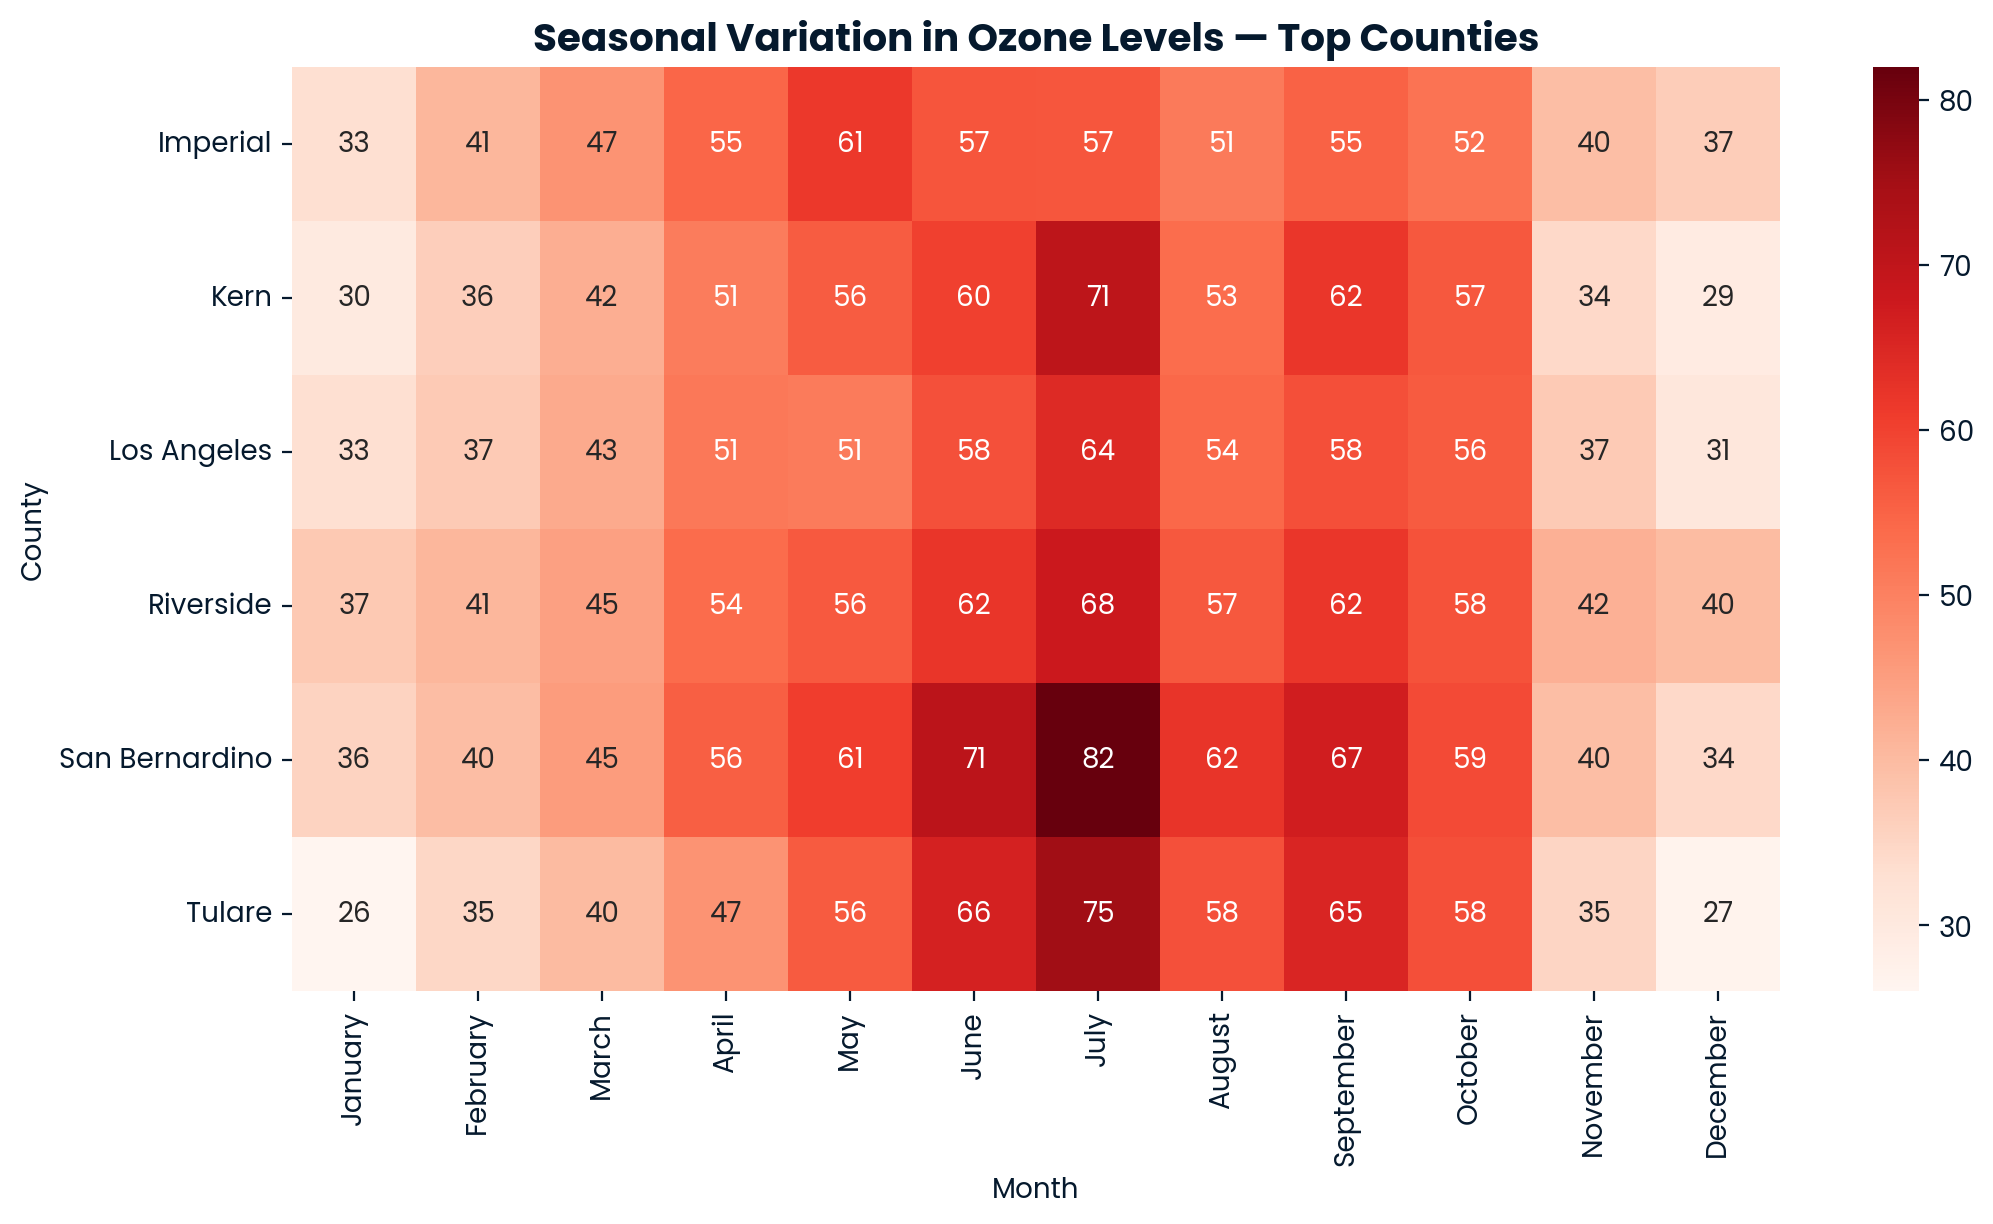

In [32]:
# Seasonal variation Heatmap
top_counties = df.groupby('County')['Ozone_ppb'].mean().nlargest(6).index
seasonal_regional = df[df['County'].isin(top_counties)].pivot_table(
    index='County', columns='Month', values='Ozone_ppb', aggfunc='mean'
).reindex(columns=[
    'January','February','March','April','May','June','July','August','September','October','November','December'
])

plt.figure(figsize=(12,6))
sns.heatmap(seasonal_regional, cmap='Reds', annot=True, fmt=".0f")
plt.title("Seasonal Variation in Ozone Levels — Top Counties", fontsize=14, weight='bold')
plt.show()


This visualization highlights seasonal ozone patterns for the six counties with the highest annual average concentrations in 2024.
By showing monthly averages in a heatmap, it reveals when each region experiences peak ozone levels, with darker shades representing higher concentrations.
The month ordering from January to December makes seasonal trends easy to follow across different counties.
This view is particularly useful for pinpointing both regional and seasonal high‑risk periods for air quality management.

### Key Insight: San Bernardino in July shows the max ozone concentration, with darker colors showing higher concentrations while lighter shades depicting the lesser values.

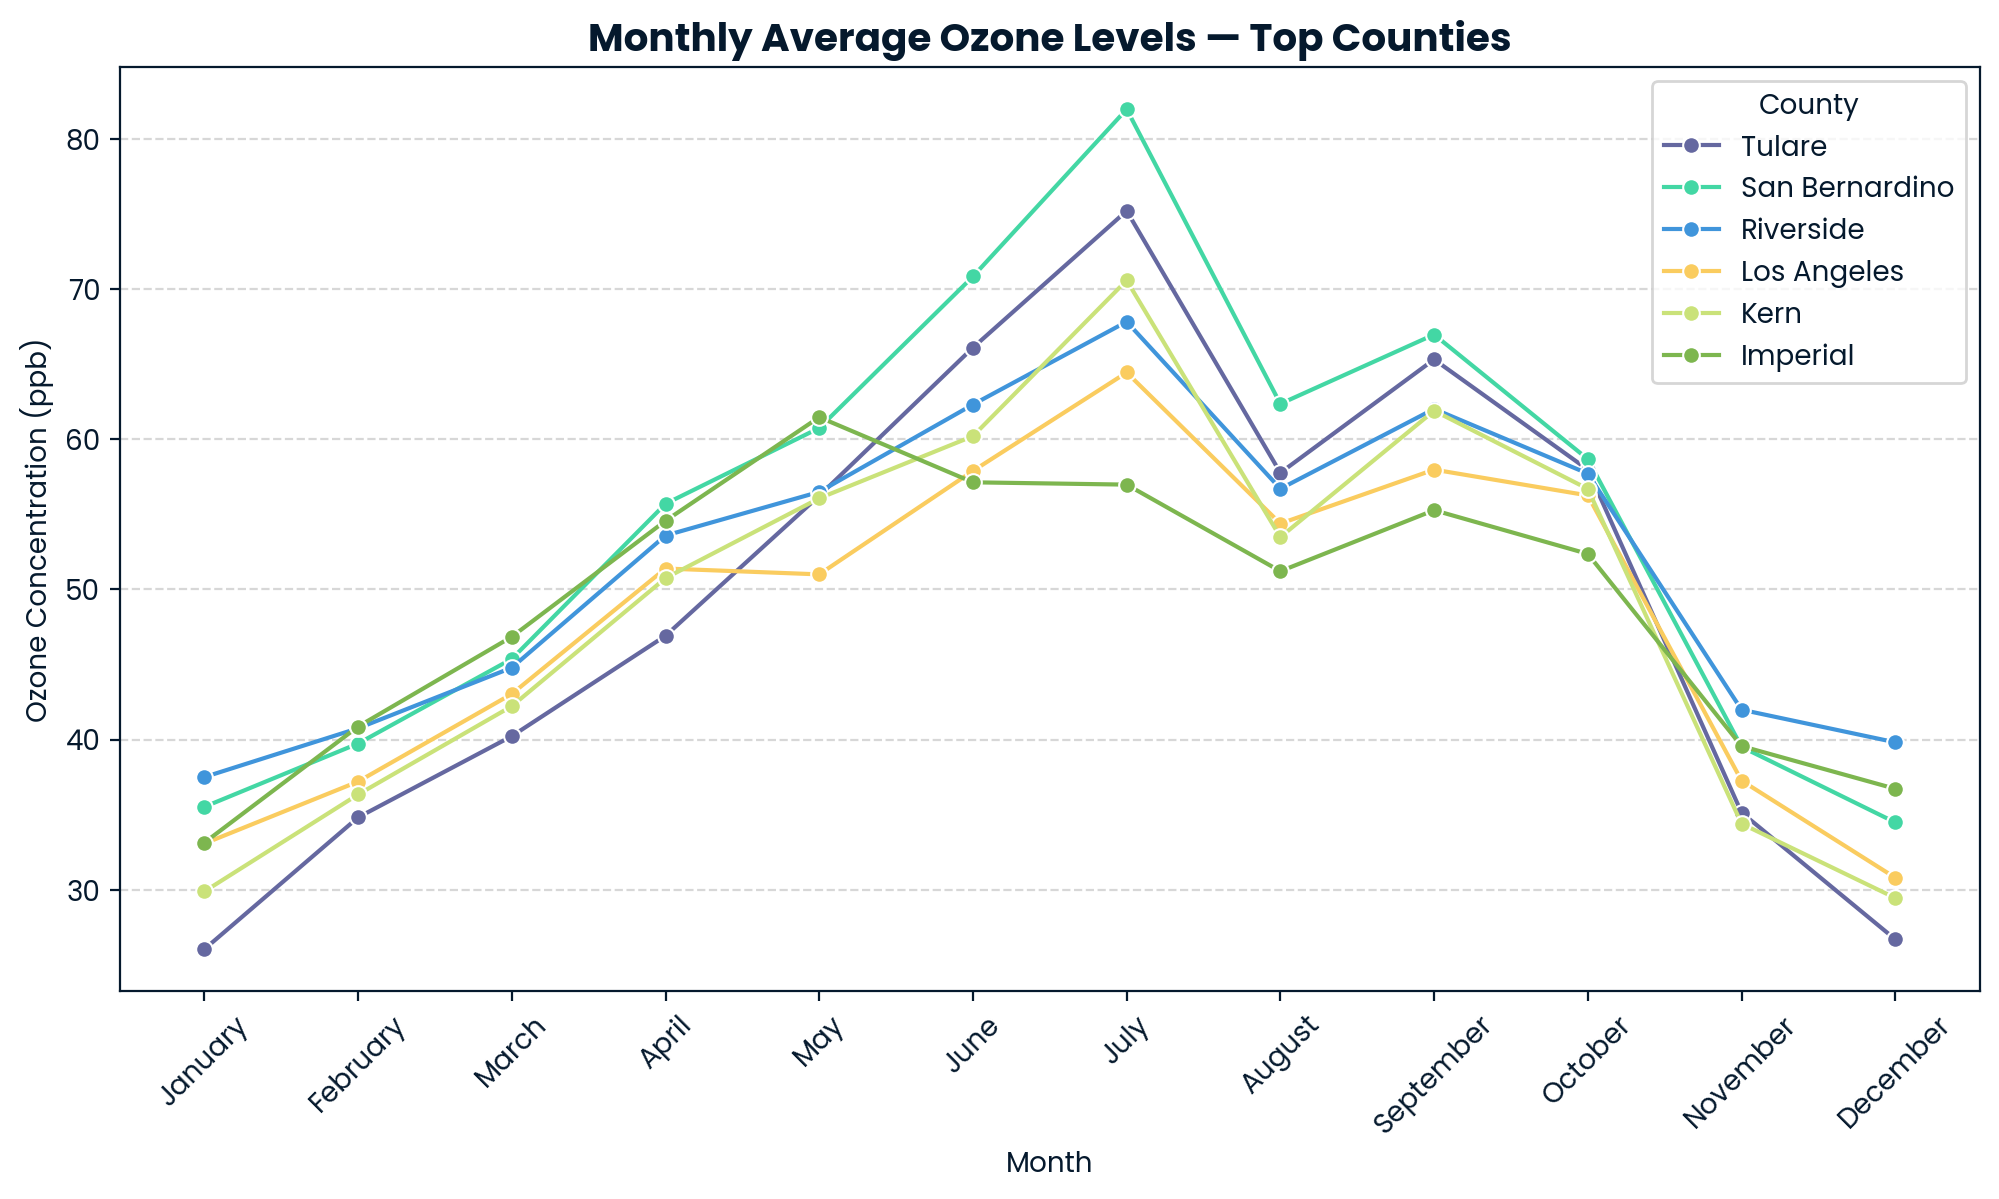

In [36]:
# Find top 6 counties by average ozone
top_counties = df.groupby('County')['Ozone_ppb'].mean().nlargest(6).index

# Monthly average for each top county
monthly_top_counties = df[df['County'].isin(top_counties)].groupby(
    [df['Date'].dt.month_name(), 'County']
)['Ozone_ppb'].mean().reset_index()

# Apply month order
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']

monthly_top_counties['Date'] = pd.Categorical(monthly_top_counties['Date'], categories=month_order, ordered=True)
monthly_top_counties = monthly_top_counties.sort_values('Date')

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_top_counties, x='Date', y='Ozone_ppb', hue='County', marker='o')
plt.title("Monthly Average Ozone Levels — Top Counties", fontsize=14, weight='bold')
plt.ylabel("Ozone Concentration (ppb)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


This visualization compares monthly ozone concentration trends for the six counties with the highest annual averages in 2024.
By plotting each county’s data as a separate line, it highlights both seasonal peaks and regional differences in ozone levels.
Markers make month‑to‑month changes more visible, while the common timeline allows direct comparison between counties.
This analysis is useful for identifying whether high‑ozone counties follow similar seasonal patterns or experience distinct regional fluctuations.

### Key Insight: This plot shows the monthly variation of the concentration levels of the top six countries, with San Bernardino having the highest peak and Imperial having the lowest.

## Summary
This analysis explores daily ozone pollution levels across California in 2024 using data from the EPA’s Air Quality System (AQS) and AirNow networks.
The dataset required extensive cleaning — including fixing inconsistent date formats, handling missing values, standardizing location names, removing duplicates, and creating derived variables for seasonal and behavioral analysis.

Key findings include:

-Seasonal variation: Ozone levels peak during summer months (July-September) across most regions, likely driven by increased sunlight and photochemical activity.

-Regional hotspots: Several inland counties consistently recorded the highest ozone concentrations, with some exceeding the EPA safety limit of 70 ppb on numerous days.

-Measurement consistency: Both AQS and AirNow sources show broadly similar seasonal patterns, though minor differences exist in reported magnitudes.

-Weekend effect: A statistical t‑test (p = 0.4827) indicates no significant difference between weekend and weekday ozone levels, suggesting urban activity changes had minimal impact in 2024.

-Spatial distribution: A geospatial heatmap highlights clear inland hotspots, with coastal areas generally recording lower ozone concentrations.

Overall, these insights can inform targeted air quality interventions by focusing on high‑risk counties and peak summer months. Consistent monitoring and cross‑verification between data sources remain essential for maintaining reliable environmental assessments.